<div>
    <img src="structure.png" width="500"/>
</div>

#### pix2pix gan using on satelite usecases. Unet for generator, Patch-gan for discriminator

#### define the model

In [24]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

In [25]:
import numpy as np
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal  #  for normalization
import tensorflow.keras as k
from tensorflow.keras.utils import plot_model  # visualize the model

import matplotlib.pyplot as plt

#### define discriminator

In [26]:
# define generator, discriminator, gan
# use defination wihout sequential, since there are several inputs
# pix2pix is a conditiional GAN with two inputs: image, label (mask)
# gan inputs: images, corresponding labels

# discriminator:
# inputs: image
# outputs: real or fake (1 or 0). Binary classification, using sigmoid activataion
# C64-C128-C256-C512. after last layer, conv to 1-dimensional ouput and activate with sigmoid

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02) # paper required
    # source image input
    in_src_image = k.layers.Input(shape=image_shape)
    # target image input
    in_target_image = k.layers.Input(shape=image_shape)
    # concatenate images on channel
    merged = k.layers.Concatenate()([in_src_image, in_target_image]) # 256X256X6
    
    # c64. 4x4 kernel, 2x2 stride
    d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)  # !!! here is initualzied
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c128. 4x4 kernel, 2x2 strides
    d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)  # !!! add batch normalization
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c256
    d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c512. not in original paper, diy for this task
    d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. stride is (1,1)
    d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch out
    d = k.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # !!! conv to 1 channel
    patch_out = k.layers.Activation('sigmoid')(d) # patch gan output real or fake, using sigmoid
    
    # define model
    model = k.models.Model([in_src_image, in_target_image], patch_out)  # inputs and outputs
    
    # compile the model
    # trained with batch size 1 under Adam
    # loss of D is weighted by 50% for each model update
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

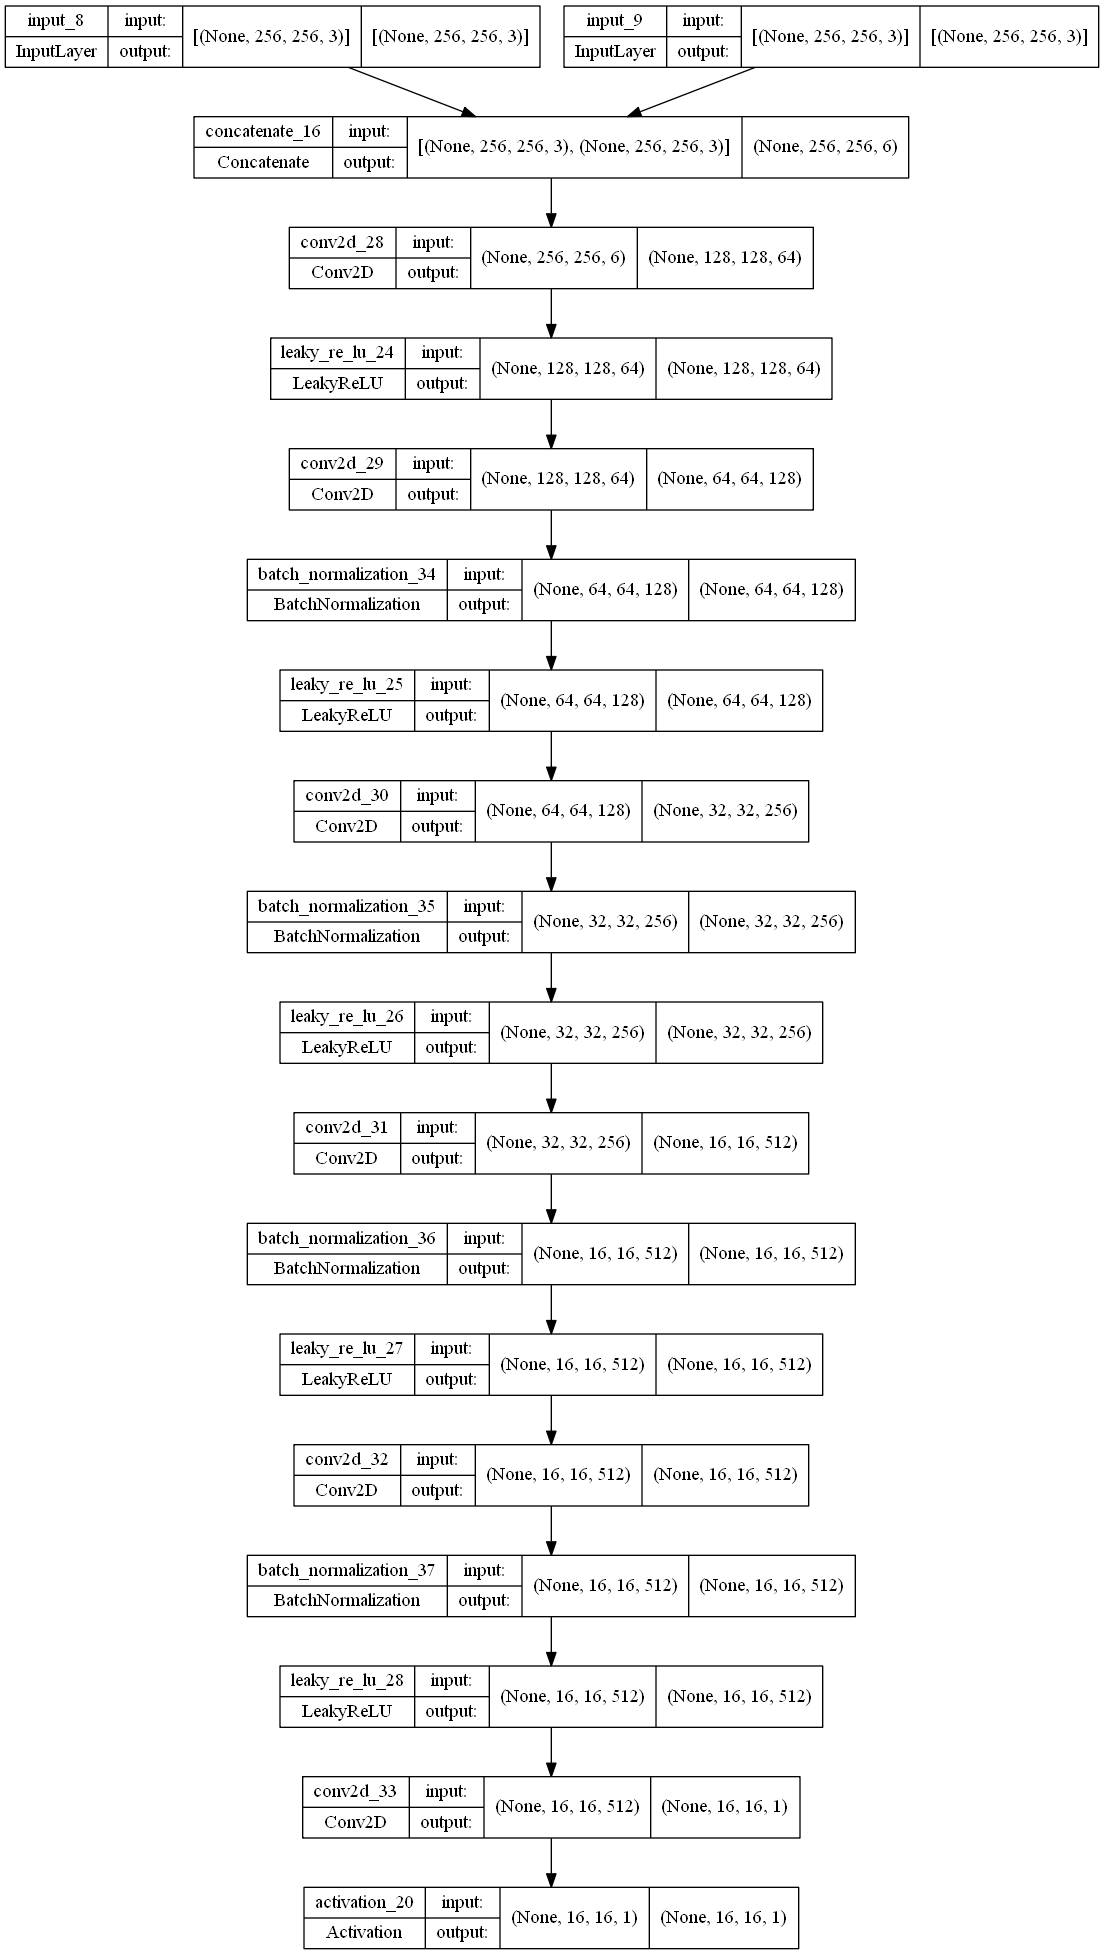

In [27]:
disc_model = define_discriminator((256, 256, 3))
plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

#### define generator

In [28]:
# define generator. in pix2pix is a Unet

# encoder block for Unet
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # downsampling layer
    g = k.layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # add batch norm accoridng to conditions
    if batchnorm:
        g = k.layers.BatchNormalization()(g, training=True) # ???
        
    # leaky relu activation
    g = k.layers.LeakyReLU(alpha=0.2)(g)
    return g
    

In [29]:
# decoder block for Unet

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # upsampling layer
    g = k.layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # batch norm
    g = k.layers.BatchNormalization()(g, training=True)
    # dropout according to conditions
    if dropout:
        g = k.layers.Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = k.layers.Concatenate()([g, skip_in])  # combine skip_in, not only AE
    # relu activation
    g = k.layers.Activation('relu')(g)
    return g

In [30]:
# compile generator model in Unet

def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape) # define the shape of input
    
    # encoder: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)  # frist layer not batchnorm. the filters must be feed
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)  # why this structure?
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = k.layers.Activation('relu')(b)
    
    # decoder: CD512-CD512-CD512-CD512-C256-C128-C64
    d1 = define_decoder_block(b, e7, 512)  # !!! skip in the last layer of encoder
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    
    # output
    g = k.layers.Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = k.layers.Activation('tanh')(g)  # generated images is from -1 to 1. remember to change inputs from -1 to 11
    # define model
    model = k.models.Model(in_image, out_image)
    return model

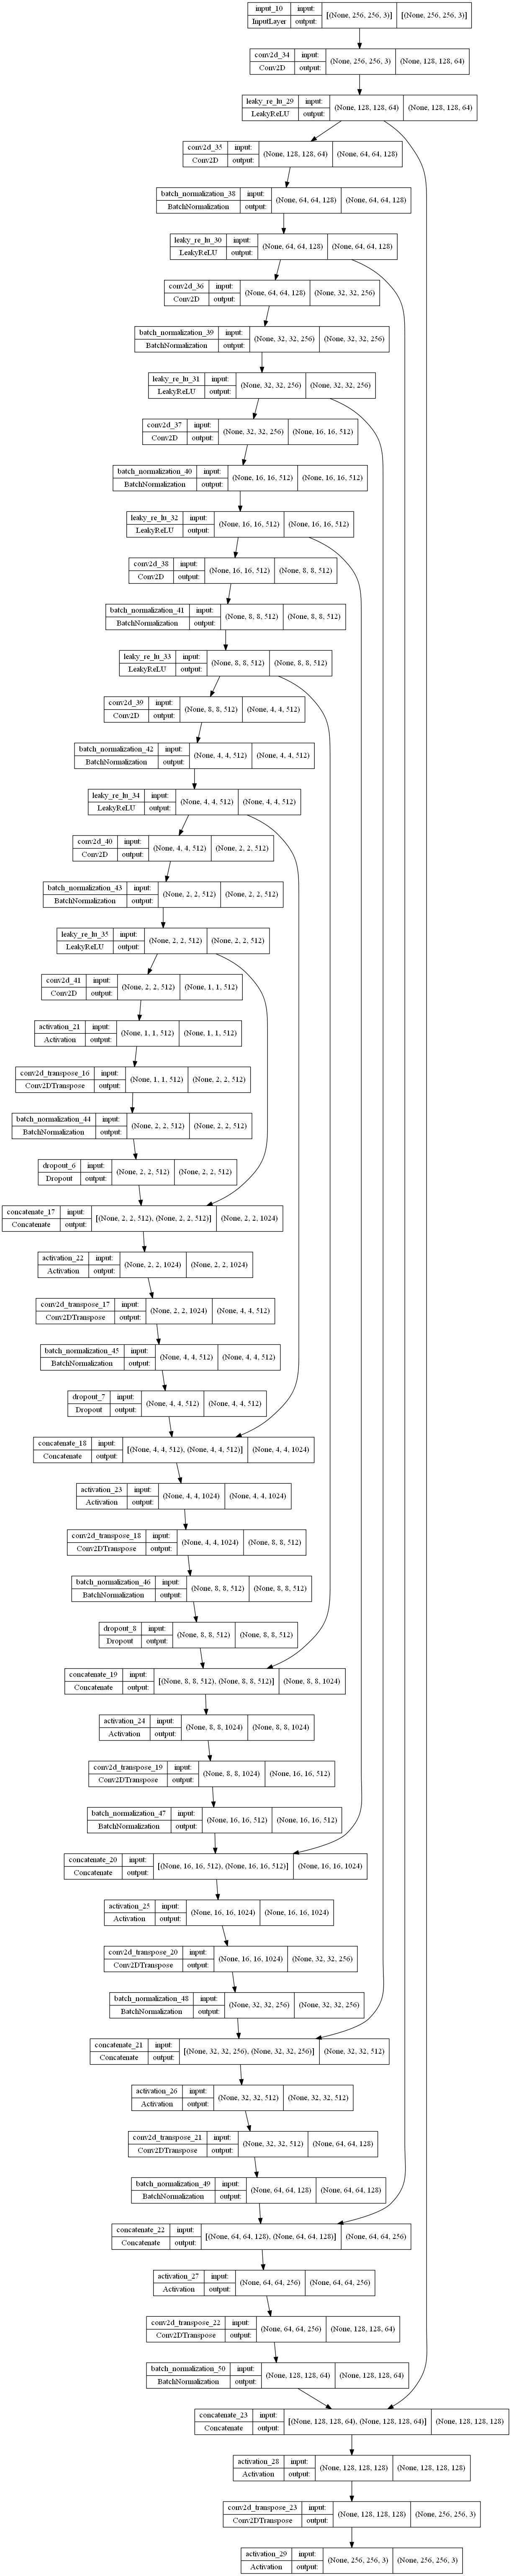

In [31]:
gen_model = define_generator((256,256,3))
plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

#### define GAN

In [32]:
# define combined G and D to update G

def define_gan(g_model, d_model, image_shape):
    # ensure the discriminator is not trainable
    d_model.trainable = False  # 定义为不可训练
#     for layer in d_model.layers:
#         if not isinstance(layer, BatchNormalization):  # ???
#             layer.trainable = False # D cannot be trained in combined GAN, but D can be trained seperately
            
    # define the source image
    in_src = k.layers.Input(shape=image_shape)
    # G: feed images to G
    gen_out = g_model(in_src)
    # D: feed input images and generated images to D
    dis_out = d_model([in_src, gen_out])
    # GAN: src image as input; generated image and ouputs of D as outputs
    model = k.models.Model(in_src, [dis_out, gen_out])
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # total loss is sum of adversarial loss (BCE) and L1 loss (MAE)
    # in paper they suggested the weight, BCE vs. L1 = 1:100
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model                    

In [33]:
# test_gan  = define_gan(gen_model, disc_model, (256,256,3))
# print(test_gan.summary())

#### data preparation

In [34]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset  # A is satelite, B is maps
    # random choose
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    # generate labels as real
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [35]:
def generate_fake_samples(g_model, samples, patch_shape):
    # generate the fake instance
    X = g_model.predict(samples)
    # create labels as 'fake'
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [36]:
# GAN does not converge. Plotting them to find a balance point
# save the generator models during them
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'sat_plot_%06d.png' % (step+1)
    plt.savefig('./pix2pix/IMG/' + filename1)
    plt.close()
    # save the generator model
    filename2 = 'sat_model_%06d.h5' % (step+1)
    g_model.save('./pix2pix/model/' + filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

#### training process

In [37]:
def train(g_model, d_model, gan_model, dataset, n_epochs=20, n_batch=1):
    # output shape of the discriminator
    n_patch = d_model.output_shape[1]  # !!! kera's function
    # unpack dataset
    trainA, trainB = dataset
    # number of the baches per epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # number of training iterations
    n_steps = bat_per_epo * n_epochs  # !!! altogether iterations
    
    # enumerate epochs
    for i in range(n_steps):
        # select batch of real images
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate batch of fake images
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update D for real images
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)  # update weights on one batch
        # update D for fake images
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # try to generate map images
        
        # update the G
        g_loss, _ , _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize the performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # model performance
#         if (i+1) % (bat_per_epo * 10) == 0:
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, dataset)
        

#### main function 

In [38]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array, load_img
from numpy import savez_compressed  # ???
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# laod all images into memory
def load_images(path, size=(256, 512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the data
        pixels = load_img(path + filename, target_size=size)
        # convert into numpy array
        pixels = img_to_array(pixels)
        # split into satelite and map
        sat_img, map_img = pixels[:,:256], pixels[:,256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

In [40]:
# data set path
path = 'F:/tuorial/python_for_microscopists-master/251-dataset/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


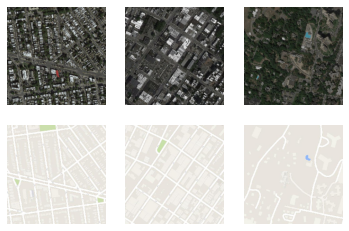

In [41]:
# sanity check

n_samples = 3

# source images
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))

# target images
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i+n_samples)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
plt.show()

In [42]:
# define parameters
image_shape = src_images.shape[1:]
# define the model
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define compiled model
gan_model = define_gan(g_model, d_model, image_shape)
# define the data
data = [src_images, tar_images]

In [43]:
data[0].shape

(1096, 256, 256, 3)

In [44]:
def preprocess_data(data):
    # load compressed arrays and unpack
    X1, X2 = data[0], data[1]
    # scale from [0, 255] into [-1,1]
    X1 = (X1-255/2)/(255/2)
    X2 = (X2-127.5)/127.5
    return [X1, X2]

In [45]:
dataset = preprocess_data(data)

In [46]:
from datetime import datetime
start1 = datetime.now() # counting the time

# reports for each batch (all 1096) for each epoch. For 10 epochs shouls see 10960
train(g_model, d_model, gan_model, dataset, n_epochs=2, n_batch=1)

stop1 = datetime.now()

>1, d1[0.424] d2[0.701] g[66.932]
>2, d1[0.367] d2[0.572] g[70.935]
>3, d1[0.366] d2[0.527] g[67.243]
>4, d1[0.339] d2[0.565] g[50.983]
>5, d1[0.412] d2[0.449] g[62.079]
>6, d1[0.407] d2[0.412] g[43.446]
>7, d1[0.383] d2[0.474] g[34.933]
>8, d1[0.441] d2[0.389] g[47.361]
>9, d1[0.321] d2[0.385] g[41.472]
>10, d1[0.408] d2[0.565] g[33.100]
>11, d1[0.350] d2[0.390] g[45.890]
>12, d1[0.423] d2[0.322] g[40.921]
>13, d1[0.181] d2[0.405] g[30.619]
>14, d1[0.389] d2[0.331] g[39.840]
>15, d1[0.307] d2[0.219] g[37.571]
>16, d1[0.261] d2[0.348] g[31.453]
>17, d1[0.239] d2[0.253] g[28.594]
>18, d1[0.206] d2[0.575] g[17.155]
>19, d1[0.247] d2[0.111] g[30.990]
>20, d1[0.844] d2[0.486] g[14.717]
>21, d1[0.022] d2[0.087] g[23.422]
>22, d1[0.218] d2[0.133] g[24.457]
>23, d1[0.219] d2[0.137] g[24.893]
>24, d1[0.072] d2[0.220] g[27.008]
>25, d1[0.122] d2[0.115] g[22.324]
>26, d1[0.087] d2[0.092] g[22.791]
>27, d1[0.392] d2[0.156] g[18.047]
>28, d1[0.210] d2[0.156] g[22.924]
>29, d1[0.067] d2[0.116] g[20

In [47]:
execution_time = stop1-start1
print("execution time: ", execution_time)

execution time:  0:04:30.596301


#### test the trained model

In [ ]:
# load trained data for test

from keras.models import load_model
from numpy.random import randint
model = load_model('sat_model_010960.h5')

In [ ]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        plt.subplot(1, 3, 1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

In [ ]:
[X1, X2] = dataset
# select random exampls
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)